<a href="https://colab.research.google.com/github/promckkon/MK-DCNN/blob/main/MK-DCNN%20with%2020dB%20NOISE%20in%20CWRU%20Dataset%20250617.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [33]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_20", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_20_faults.csv',index=False)

/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_20/Noise_20_IR007_1_110.mat
['Noise_20_IR007_1_110']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_20/Noise_20_B014_1_190.mat


<ipython-input-33-1130502457>:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['Noise_20_IR007_1_110' 'Noise_20_B014_1_190']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_20/Noise_20__Time_Normal_1_098.mat
['Noise_20_IR007_1_110' 'Noise_20_B014_1_190'
 'Noise_20__Time_Normal_1_098']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_20/Noise_20_IR021_1_214.mat
['Noise_20_IR007_1_110' 'Noise_20_B014_1_190'
 'Noise_20__Time_Normal_1_098' 'Noise_20_IR021_1_214']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_20/Noise_20_OR021_6_1_239.mat
['Noise_20_IR007_1_110' 'Noise_20_B014_1_190'
 'Noise_20__Time_Normal_1_098' 'Noise_20_IR021_1_214'
 'Noise_20_OR021_6_1_239']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_20/Noise_20_OR007_6_1_136.mat
['Noise_20_IR007_1_110' 'Noise_20_B014_1_190'
 'Noise_20__Time_Normal_1_098' 'Noise_20_IR021_1_214'
 'Noise_20_OR021_6_1_239' 'Noise_20_OR007_6_1_136']
/content/drive/MyDrive/CWRU_with_NOISE/CWRU_2_NOISE_20/Noise_20_OR014_6_1_202.mat
['Noise_20_IR007_1_110' 'Noise_20_B014_1_190'
 'Noise_20__Time_Normal_1_098' 'Nois

# Multi-Kernel Deep 1D-CNN

In [34]:
pip install -q tensorflow

In [35]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [36]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras import backend as K

# --- Custom Physics-Informed Loss Function ---
def custom_loss(y_true, y_pred):
    # Standard categorical crossentropy
    loss = K.categorical_crossentropy(y_true, y_pred)

    # Physics-Informed Term: penalize rapid class probability changes
    # Ensure y_pred is at least 2D for slicing
    if K.ndim(y_pred) < 2:
        y_pred = K.expand_dims(y_pred, axis=-1)

    # Ensure y_pred has more than one class dimension to compute diff
    if K.int_shape(y_pred)[-1] > 1:
        diff = y_pred[:, 1:] - y_pred[:, :-1]
        squared_diff = tf.square(diff)
        physics_term = tf.reduce_mean(squared_diff)
    else:
        physics_term = 0.0 # No physics term if only one class


    # Total loss = classification loss + regularization term
    total_loss = loss + 0.01 * physics_term  # 0.01 is tunable

    return total_loss

# --- Model Definition ---
# no_classes = len(df['fault'].unique()) # Original line that caused 10 classes
no_classes = len(encoder.classes_) # Use the encoder to get the correct number of classes
print(f"Number of output classes (no_classes): {no_classes}") # Add print statement to verify

input_shape = (X.shape[1], X.shape[2])  # Example: (784, 1)

# Head 1
inputs1 = Input(shape=input_shape)
conv1 = Conv1D(filters=64, kernel_size=200, activation='relu')(inputs1)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=20)(drop1)
flat1 = Flatten()(pool1)

# Head 2
inputs2 = Input(shape=input_shape)
conv2 = Conv1D(filters=64, kernel_size=100, activation='relu')(inputs2)
drop2 = Dropout(0.5)(conv2)
pool2 = MaxPooling1D(pool_size=10)(drop2)
flat2 = Flatten()(pool2)

# Head 3
inputs3 = Input(shape=input_shape)
conv3 = Conv1D(filters=64, kernel_size=50, activation='relu')(inputs3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPooling1D(pool_size=5)(drop3)
flat3 = Flatten()(pool3)

# Merge all feature paths
merged = concatenate([flat1, flat2, flat3])

# Fully connected interpretation
dense1 = Dense(100, activation='relu')(merged)
outputs = Dense(no_classes, activation='softmax')(dense1)

# Build and compile model with custom loss
cnn_model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
cnn_model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

# Model summary
cnn_model.summary()

Number of output classes (no_classes): 9


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 2431, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 2431, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 2431, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 2232, 64)  │     12,864 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 2332, 64)  │      6,464 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 2382, 64)  │      3,264 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2232, 64)  │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2332, 64)  │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 2382, 64)  │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 111, 64)   │          0 │ dropout_3[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 233, 64)   │          0 │ dropout_4[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 476, 64)   │          0 │ dropout_5[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 7104)      │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 14912)     │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 30464)     │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 52480)     │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten_4[0][0],  │
│                     │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │  5,248,100 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 9)         │        909 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,271,601 (20.11 MB)

 Trainable params: 5,271,601 (20.11 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
batch_size =100
epochs = 20
history = cnn_model.fit([X_train,X_train,X_train], y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=([X_test,X_test,X_test],y_test),shuffle=True)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 793ms/step - accuracy: 0.1292 - loss: 4.0359 - val_accuracy: 0.2774 - val_loss: 3.4610
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.3499 - loss: 3.0328 - val_accuracy: 0.5252 - val_loss: 3.1144
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6049 - loss: 2.4451 - val_accuracy: 0.7033 - val_loss: 2.7507
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7648 - loss: 2.1603 - val_accuracy: 0.8101 - val_loss: 2.4428
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8585 - loss: 1.8760 - val_accuracy: 0.8220 - val_loss: 2.2708
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8702 - loss: 1.8785 - val_accuracy: 0.8457 - val_loss: 2.2069
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8885 - loss: 1.7492 - val_accuracy: 0.8546 - val_loss: 2.1841
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8808 - loss: 1.7544 - val_accuracy: 0.8427 

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


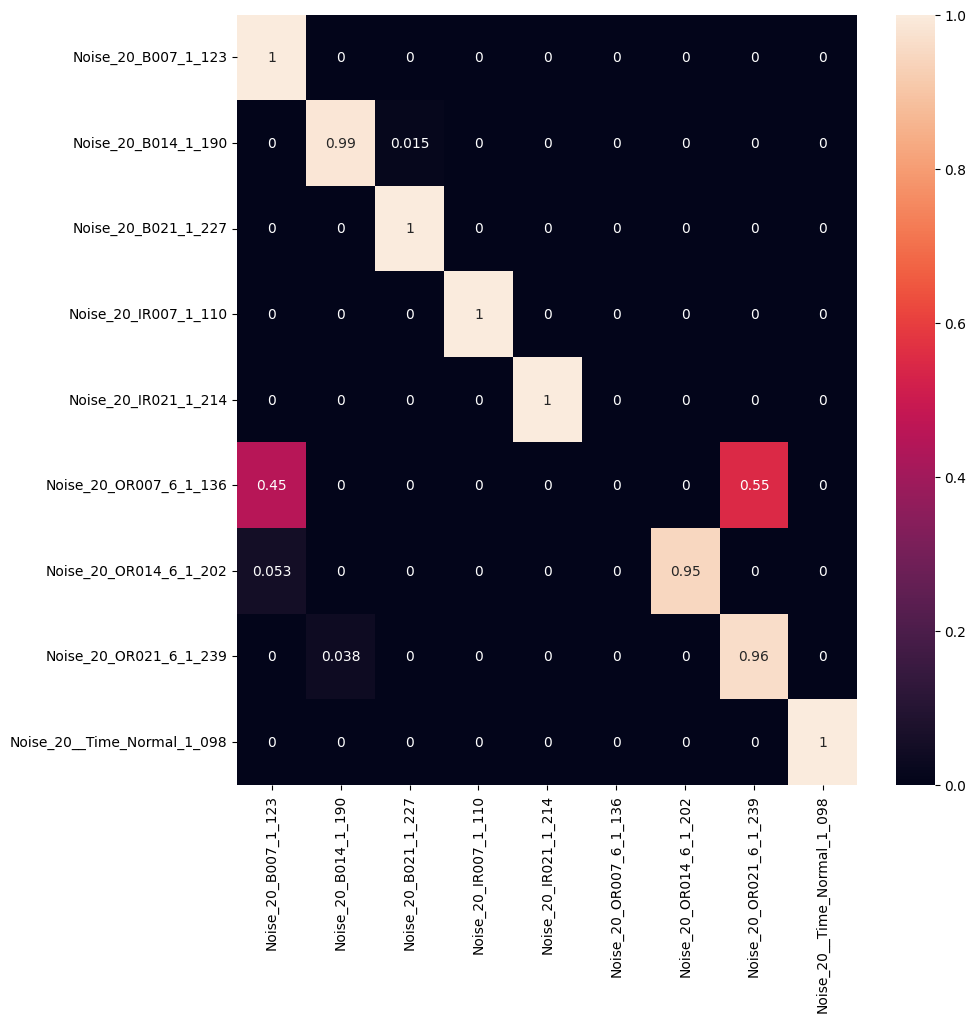

In [39]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict([X_test,X_test,X_test])


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)

In [40]:
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[16].output)
y_viz = dummy_cnn.predict([X_train,X_train,X_train])

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1570 samples in 0.001s...
[t-SNE] Computed neighbors for 1570 samples in 0.103s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1570
[t-SNE] Computed conditional probabilities for sample 1570 / 1570
[t-SNE] Mean sigma: 1.461009
[t-SNE] Computed conditional probabilities in 0.054s


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Iteration 50: error = 56.1817322, gradient norm = 0.0424379 (50 iterations in 0.585s)
[t-SNE] Iteration 100: error = 51.3544998, gradient norm = 0.0159742 (50 iterations in 0.430s)
[t-SNE] Iteration 150: error = 50.1776962, gradient norm = 0.0103157 (50 iterations in 0.529s)
[t-SNE] Iteration 200: error = 49.6091385, gradient norm = 0.0076135 (50 iterations in 0.628s)
[t-SNE] Iteration 250: error = 49.2475281, gradient norm = 0.0062203 (50 iterations in 0.622s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.247528
[t-SNE] Iteration 300: error = 0.8690901, gradient norm = 0.0153982 (50 iterations in 0.639s)
[t-SNE] Iteration 350: error = 0.6226915, gradient norm = 0.0142080 (50 iterations in 0.696s)
[t-SNE] Iteration 400: error = 0.5199080, gradient norm = 0.0121171 (50 iterations in 0.653s)
[t-SNE] Iteration 450: error = 0.4679767, gradient norm = 0.0107420 (50 iterations in 0.459s)
[t-SNE] Iteration 500: error = 0.4375235, gradient norm = 0.0096210 (50 

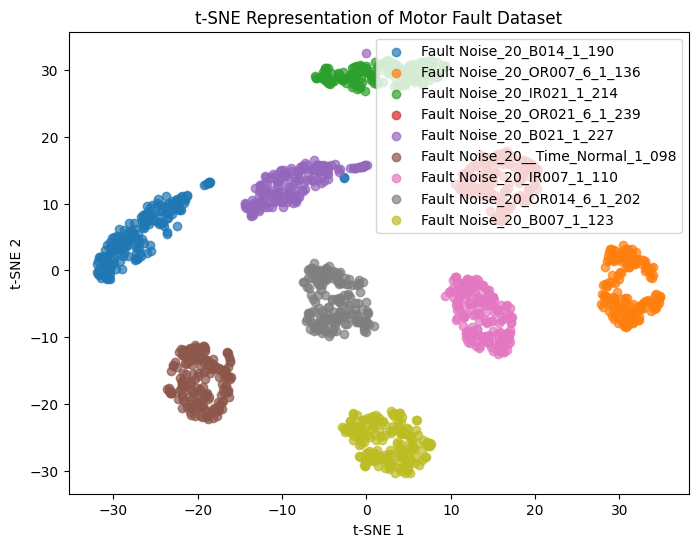

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Apply t-SNE transformation
X_t_sne = TSNE(
    n_components=2,
    learning_rate='auto',
    verbose=2,  # Increase verbosity for more detailed feedback
    perplexity=40,
    n_iter=500  # Slightly increased number of iterations for convergence
).fit_transform(y_viz)

# Create DataFrame for t-SNE components
tSNEdf = pd.DataFrame(data=X_t_sne, columns=['T-SNE component 1', 'T-SNE component 2'])

# Assuming `inv_Transform_result` transforms `y_train` to get the Fault labels
tSNEdf['Fault'] = inv_Transform_result(y_train)

# Save the t-SNE DataFrame as a CSV file
tSNEdf.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_20_tSNE_results.csv', index=True)
print("t-SNE results saved as '/content/drive/MyDrive/MK-DCNN CWRU/NOISE_20_tSNE_results.csv'.")

# # Plot the t-SNE results with Fault as hue
# plt.figure(figsize=(12, 12))  # Larger figure for clarity
# sns.scatterplot(
#     x='T-SNE component 1',
#     y='T-SNE component 2',
#     hue='Fault',
#     palette=sns.color_palette("husl", as_cmap=False),  # Vivid color palette
#     data=tSNEdf,
#     legend="full",
#     alpha=0.7,  # Increased transparency for better overlap clarity
#     s=100  # Larger marker size
# )

# # Add gridlines for better visualization
# plt.grid


# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNEdf['Fault'].unique():
    subset = tSNEdf[tSNEdf['Fault'] == label]
    plt.scatter(subset['T-SNE component 1'], subset['T-SNE component 2'], label=f'Fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

Statistical Features

In [42]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NOISE_20_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")


Calculated WINDOW_SIZE: 2431, STRIDE: 1944
Extracted 2244 rows (target: 1800)
                     fault  window      mean       std       rms       max  \
0     Noise_20_IR007_1_110       1  0.021539  0.284861  0.285674  1.586676   
1     Noise_20_IR007_1_110       2  0.022262  0.285338  0.286205  1.353412   
2     Noise_20_IR007_1_110       3  0.019707  0.274768  0.275473  1.549092   
3     Noise_20_IR007_1_110       4  0.021170  0.282469  0.283262  1.415228   
4     Noise_20_IR007_1_110       5  0.021637  0.277999  0.278840  1.557334   
...                    ...     ...       ...       ...       ...       ...   
2239   Noise_20_B021_1_227     246  0.013300  0.194222  0.194677  0.598591   
2240   Noise_20_B021_1_227     247  0.015658  0.187913  0.188565  0.598591   
2241   Noise_20_B021_1_227     248  0.015957  0.147979  0.148837  0.617769   
2242   Noise_20_B021_1_227     249  0.014393  0.184386  0.184947  0.654264   
2243   Noise_20_B021_1_227     250  0.014081  0.181083  0.181630

In [43]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_20_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK-DCNN CWRU/NOISE_20_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NOISE_20_balanced_dataset_equal_resampling_exact_1570.csv'")


Initial class distribution:
fault
Noise_20_OR021_6_1_239         251
Noise_20_B007_1_123            250
Noise_20_B021_1_227            250
Noise_20_OR007_6_1_136         250
Noise_20_IR007_1_110           249
Noise_20_B014_1_190            249
Noise_20_IR021_1_214           249
Noise_20__Time_Normal_1_098    248
Noise_20_OR014_6_1_202         248
Name: count, dtype: int64
Current rows after equal resampling: 1566
New class distribution:
fault
Noise_20_OR014_6_1_202         175
Noise_20_IR021_1_214           175
Noise_20__Time_Normal_1_098    175
Noise_20_IR007_1_110           175
Noise_20_B014_1_190            174
Noise_20_OR007_6_1_136         174
Noise_20_B021_1_227            174
Noise_20_B007_1_123            174
Noise_20_OR021_6_1_239         174
Name: count, dtype: int64
Final row count: 1570
Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NOISE_20_balanced_dataset_equal_resampling_exact_1570.csv'


In [44]:
balanced_df.shape

(1570, 11)

In [45]:
balanced_df=balanced_df.sort_values(by='fault')

In [46]:
balanced_df

,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
101,Noise_20_B007_1_123,65,0.019177,0.124292,0.125763,0.436231,-0.329550,0.036383,-0.190864,1.251902,3.468669
125,Noise_20_B007_1_123,1,0.019461,0.125228,0.126731,0.418728,-0.427906,-0.080988,-0.065711,1.248037,3.304075
1352,Noise_20_B007_1_123,42,0.020267,0.144646,0.146059,0.434687,-0.442048,-0.066199,-0.295157,1.237866,2.976109
1353,Noise_20_B007_1_123,101,0.017768,0.138824,0.139956,0.500270,-0.422239,0.029395,0.236381,1.269766,3.574472
1469,Noise_20_B007_1_123,241,0.019190,0.146410,0.147662,0.505042,-0.565174,-0.028410,0.429802,1.271448,3.420254
...,...,...,...,...,...,...,...,...,...,...,...
565,Noise_20__Time_Normal_1_098,153,0.011774,0.067514,0.068533,0.201298,-0.219301,-0.273959,-0.044652,1.243141,2.937255
184,Noise_20__Time_Normal_1_098,148,0.010847,0.066774,0.067649,0.238132,-0.187446,-0.102387,-0.139532,1.240396,3.520113
1130,Noise_20__Time_Normal_1_098,17,0.010031,0.063425,0.064213,0.201127,-0.251943,-0.213459,-0.075773,1.232101,3.132200
441,Noise_20__Time_Normal_1_098,40,0.010648,0.063420,0.064308,0.195499,-0.170126,-0.158017,-0.367093,1.223274,3.040056


     t-SNE 1    t-SNE 2                fault
0  25.732910  16.688488  Noise_20_B007_1_123
1  40.695522   5.601993  Noise_20_B007_1_123
2  23.914379  17.773241  Noise_20_B007_1_123
3  38.367844   0.672475  Noise_20_B007_1_123
4  37.629719   0.749252  Noise_20_B007_1_123


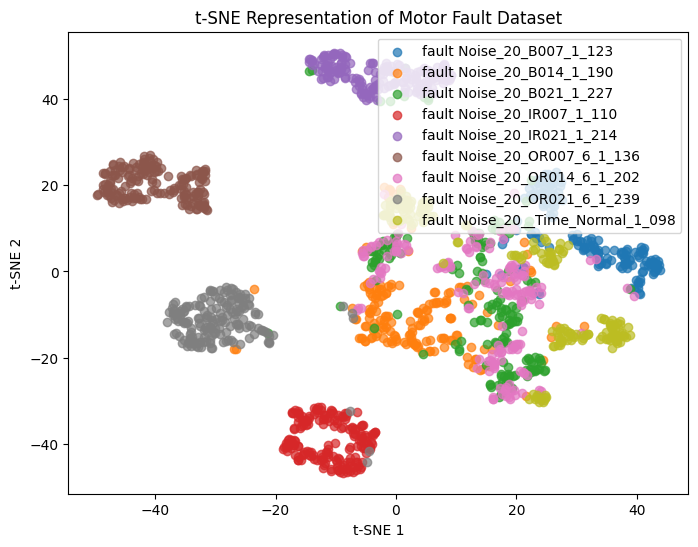

In [47]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


In [48]:
tSNE_representation

,t-SNE 1,t-SNE 2,fault
0,25.732910,16.688488,Noise_20_B007_1_123
1,40.695522,5.601993,Noise_20_B007_1_123
2,23.914379,17.773241,Noise_20_B007_1_123
3,38.367844,0.672475,Noise_20_B007_1_123
4,37.629719,0.749252,Noise_20_B007_1_123
...,...,...,...
1565,25.535168,3.862620,Noise_20__Time_Normal_1_098
1566,4.407224,15.866333,Noise_20__Time_Normal_1_098
1567,2.453275,10.752535,Noise_20__Time_Normal_1_098
1568,3.589916,12.759286,Noise_20__Time_Normal_1_098


In [49]:
tSNE_representation=tSNE_representation.drop(columns=['fault'])
tSNE_representation

,t-SNE 1,t-SNE 2
0,25.732910,16.688488
1,40.695522,5.601993
2,23.914379,17.773241
3,38.367844,0.672475
4,37.629719,0.749252
...,...,...
1565,25.535168,3.862620
1566,4.407224,15.866333
1567,2.453275,10.752535
1568,3.589916,12.759286


In [50]:
tSNEdf = tSNEdf.sort_values(by='Fault')

In [51]:
tSNEdf

,T-SNE component 1,T-SNE component 2,Fault
784,-0.268092,-25.661104,Noise_20_B007_1_123
650,0.468088,-27.683455,Noise_20_B007_1_123
646,4.468990,-24.421198,Noise_20_B007_1_123
645,4.835988,-28.794012,Noise_20_B007_1_123
640,7.478864,-26.297018,Noise_20_B007_1_123
...,...,...,...
719,-20.513409,-15.538752,Noise_20__Time_Normal_1_098
900,-16.148027,-16.332129,Noise_20__Time_Normal_1_098
899,-18.180286,-22.053024,Noise_20__Time_Normal_1_098
614,-16.157112,-13.776140,Noise_20__Time_Normal_1_098


Combined Features

In [52]:
# import pandas as pd

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)
Motor_Fault_dataset=Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

# Assuming df1 and df2 are your two dataframes
# Concatenate the dataframes vertically
Motor_Fault_dataset = pd.concat([tSNE_representation, tSNEdf], axis=1)

# Sort the dataset by 'Fault' column
Motor_Fault_dataset = Motor_Fault_dataset.sort_values(by='Fault')
Motor_Fault_dataset


,t-SNE 1,t-SNE 2,T-SNE component 1,T-SNE component 2,Fault
784,5.706754,46.173515,-0.268092,-25.661104,Noise_20_B007_1_123
650,-5.694093,-44.144920,0.468088,-27.683455,Noise_20_B007_1_123
646,-5.465993,-35.657150,4.468990,-24.421198,Noise_20_B007_1_123
645,-8.449287,-32.704254,4.835988,-28.794012,Noise_20_B007_1_123
640,-7.694631,-46.336590,7.478864,-26.297018,Noise_20_B007_1_123
...,...,...,...,...,...
719,-12.512770,49.211769,-20.513409,-15.538752,Noise_20__Time_Normal_1_098
900,-36.106422,19.907265,-16.148027,-16.332129,Noise_20__Time_Normal_1_098
899,-42.584270,16.786142,-18.180286,-22.053024,Noise_20__Time_Normal_1_098
614,-4.658203,-39.995380,-16.157112,-13.776140,Noise_20__Time_Normal_1_098


In [53]:
#Classification Report for MKDCNN

HSPSO-CatBoost


In [54]:
X = Motor_Fault_dataset.iloc[:, 0:4].values
y = Motor_Fault_dataset.iloc[:, 4].values

In [55]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [56]:
pip install -q hyperactive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 6.2 MB/s eta 0:00:00


In [57]:
pip install -q catboost

Deployment:

In [58]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier, Pool
from hyperactive import Hyperactive
from hyperactive.optimizers import ParticleSwarmOptimizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === DATA: Replace X_train, X_test, y_train, y_test with your actual data ===
# Example:
# X_train, X_test, y_train, y_test = train_test_split(...)

X, y = X_train, y_train

# === Objective Function ===
def model(opt):
    CatBoost = CatBoostClassifier(
        iterations=opt["iterations"],
        depth=opt["depth"],
        learning_rate=opt["learning_rate"],
        l2_leaf_reg=opt["l2_leaf_reg"],
        bagging_temperature=opt["bagging_temperature"],
        random_strength=opt["random_strength"],
        verbose=False
    )
    scores = cross_val_score(CatBoost, X, y, cv=4)
    return scores.mean()

# === Search Space ===
search_space = {
    "iterations": list(range(50, 501, 50)),
    "depth": list(range(1, 11)),
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5],
    "bagging_temperature": [0.5, 1, 1.5],
    "random_strength": [0.5, 1, 1.5],
}

# === Cauchy Mutation ===
def cauchy_mutation(particle, gamma=0.3):
    for key in particle:
        if isinstance(particle[key], (int, float)):
            particle[key] = particle[key] * (1 + gamma * np.tan(np.pi * (np.random.rand() - 0.5)))
            particle[key] = np.clip(particle[key], min(search_space[key]), max(search_space[key]))
            if isinstance(search_space[key][0], int):
                particle[key] = int(round(particle[key]))
    return particle

# === HSPSO Optimizer Class ===
class HybridStrategyPSO(ParticleSwarmOptimizer):
    def __init__(self, n_part=20, max_iter=40, **kwargs):
        super().__init__(**kwargs)
        self.switch_threshold = 10
        self.iteration = 0
        self.topology = "gbest"
        self.n_part = n_part
        self.max_iter = max_iter

        # Adaptive Inertia Parameters
        self.H = 1
        self.w_min = 0.4
        self.w_max = 0.9
        self.b = 0.9
        self.scaling_factor = 0.5

    def on_iteration(self, swarm, scores):
        self.iteration += 1

        # === Topology Switching ===
        if self.iteration % self.switch_threshold == 0:
            self.topology = "lbest" if self.topology == "gbest" else "gbest"
            self.set_topology(self.topology)

        # === Clone Best Particles ===
        best_indices = np.argsort(scores)[:max(1, len(swarm) // 5)]
        for idx in best_indices:
            particle = swarm[idx].copy()
            swarm.append(particle)
            scores.append(scores[idx])

        # === Prune Worst Particles ===
        if len(swarm) > 2 * self.n_part:
            worst_indices = np.argsort(scores)[-len(swarm)//4:]
            for i in reversed(worst_indices):
                del swarm[i]
                del scores[i]

        # === Nonlinear Adaptive Inertia ===
        numerator = (self.w_max - self.w_min) * self.iteration
        denominator = 1 + np.exp(-10 * self.b * ((2 * self.iteration) / (self.H * self.max_iter) - 1))
        self.inertia = self.w_max - numerator / denominator

        # === Cauchy Mutation ===
        for i in range(len(swarm)):
            if np.random.rand() < 0.2:
                swarm[i] = cauchy_mutation(swarm[i])

        # === Hook-Jeeves Local Search (simplified) ===
        top_ids = np.argsort(scores)[:2]
        for i in top_ids:
            particle = swarm[i]
            for key in particle:
                if isinstance(particle[key], (int, float)):
                    for delta in [-0.01, 0.01] if isinstance(particle[key], float) else [-1, 1]:
                        trial = particle.copy()
                        trial[key] = trial[key] + delta
                        trial[key] = np.clip(trial[key], min(search_space[key]), max(search_space[key]))
                        if isinstance(search_space[key][0], int):
                            trial[key] = int(round(trial[key]))
                        trial_score = model(trial)
                        if trial_score > scores[i]:
                            swarm[i] = trial
                            scores[i] = trial_score

        # === Random Restart ===
        if np.random.rand() < 0.1:
            random_idx = np.random.choice(len(swarm))
            for key in swarm[random_idx]:
                if isinstance(swarm[random_idx][key], (int, float)):
                    swarm[random_idx][key] = np.random.choice(search_space[key])

# === Run HSPSO Hyperparameter Tuning ===
start_time = datetime.now()

hyper = Hyperactive()

optimizer = HybridStrategyPSO(
    n_part=20,
    max_iter=40,
    inertia=0.5,
    cognitive_weight=0.9,
    social_weight=0.5,
    temp_weight=0.4,
    rand_rest_p=0.05,
)

hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40)
hyper.run()

end_time = datetime.now()
print('Tuning Duration:', end_time - start_time)

# === Best Parameters ===
best_params = hyper.best_para(model)
print("Best Parameters:", best_params)

# === Train Final Model with Best Parameters ===
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

final_model = CatBoostClassifier(
    depth=best_params["depth"],
    iterations=best_params["iterations"],
    learning_rate=best_params["learning_rate"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    bagging_temperature=best_params["bagging_temperature"],
    random_strength=best_params["random_strength"],
    verbose=10
)

final_model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=best_params["iterations"] // 10,
    plot=True
)


[0] model (Particle Swarm Optimization): 100%|──────────| 40/40 [09:19<00:00, 13.99s/it, best_iter=0, best_pos=None, best_score=-inf]



Results: 'model'  
   Best score: 0.9984076433121019  
   Best parameter set:
      'iterations'          : 500.0  
      'depth'               : 10.0  
      'learning_rate'       : 0.05  
      'l2_leaf_reg'         : 1.0  
      'bagging_temperature' : 1.0  
      'random_strength'     : 1.5  
   Best iteration: 0  
 
   Random seed: 1296411839  
 
   Evaluation time   : 559.3957583904266 sec    [100.0 %]
   Optimization time : 0.013435840606689453 sec    [0.0 %]
   Iteration time    : 559.4091942310333 sec    [13.99 sec/iter]
 
Tuning Duration: 0:09:19.682105
Best Parameters: {'iterations': 500, 'depth': 10, 'learning_rate': 0.05, 'l2_leaf_reg': 1, 'bagging_temperature': 1, 'random_strength': 1.5}


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.9227818	test: 1.9304102	best: 1.9304102 (0)	total: 104ms	remaining: 52.1s
50:	learn: 0.1250241	test: 0.1409830	best: 0.1409830 (50)	total: 4.95s	remaining: 43.6s
100:	learn: 0.0331267	test: 0.0499806	best: 0.0499806 (100)	total: 10.1s	remaining: 39.9s
150:	learn: 0.0150191	test: 0.0324002	best: 0.0324002 (150)	total: 15.9s	remaining: 36.8s
200:	learn: 0.0080939	test: 0.0266625	best: 0.0266625 (200)	total: 20.7s	remaining: 30.8s
250:	learn: 0.0047603	test: 0.0246514	best: 0.0246514 (250)	total: 26.9s	remaining: 26.7s
300:	learn: 0.0034151	test: 0.0242604	best: 0.0242405 (293)	total: 31.2s	remaining: 20.6s
350:	learn: 0.0026184	test: 0.0242552	best: 0.0242307 (316)	total: 35.9s	remaining: 15.3s
400:	learn: 0.0021233	test: 0.0244397	best: 0.0242307 (316)	total: 42s	remaining: 10.4s
450:	learn: 0.0018285	test: 0.0245751	best: 0.0242307 (316)	total: 46.6s	remaining: 5.06s
499:	learn: 0.0015993	test: 0.0247875	best: 0.0242307 (316)	total: 52.4s	remaining: 0us

bestTest = 0.024230

In [59]:
hyper.add_search(model, search_space, optimizer=optimizer, n_iter=40, initialize={"random": 20})


In [60]:
learning_curve = final_model.get_evals_result()
print(learning_curve)

{'learn': {'MultiClass': [1.9227817763405832, 1.7397596603616738, 1.564162620149233, 1.4144037712406916, 1.2873022067623279, 1.1818946959146448, 1.0937570186762229, 1.008341398855212, 0.9359432101922838, 0.8733367692466644, 0.8171683174523082, 0.7677499762494199, 0.7176292692237851, 0.6781341108981815, 0.6436034781558659, 0.605779079002907, 0.575952925458804, 0.5459592045681677, 0.5154021272254697, 0.48842236174854087, 0.4656224525745242, 0.44187828325749023, 0.4207448210587798, 0.39812678555545705, 0.3795644378879558, 0.3610997347990883, 0.3441240537806602, 0.32861655893942904, 0.3136667339658492, 0.2989560380781072, 0.2854546064878377, 0.2733089661163899, 0.2625253086054396, 0.2512918470290543, 0.23996085108593057, 0.2303909130380692, 0.22155261096079157, 0.21177009110341644, 0.20281898130951934, 0.1941087246948423, 0.18546523298328316, 0.1777615848589516, 0.17151008990042668, 0.1652824566585993, 0.15846721960730253, 0.1523900093086955, 0.14630226677740726, 0.14033079364586096, 0.134

In [61]:
# Retrieve evaluation results
learning_curve = final_model.get_evals_result()

# Extract the metric values
# Assuming 'learn' corresponds to the training dataset
train_metric_values = learning_curve.get('learn', {}).get('MultiClass', [])

# Check the extracted values
if train_metric_values:
    print("Training metric values:", train_metric_values)
else:
    print("Metric 'MultiClass' not found in evaluation results.")


Training metric values: [1.9227817763405832, 1.7397596603616738, 1.564162620149233, 1.4144037712406916, 1.2873022067623279, 1.1818946959146448, 1.0937570186762229, 1.008341398855212, 0.9359432101922838, 0.8733367692466644, 0.8171683174523082, 0.7677499762494199, 0.7176292692237851, 0.6781341108981815, 0.6436034781558659, 0.605779079002907, 0.575952925458804, 0.5459592045681677, 0.5154021272254697, 0.48842236174854087, 0.4656224525745242, 0.44187828325749023, 0.4207448210587798, 0.39812678555545705, 0.3795644378879558, 0.3610997347990883, 0.3441240537806602, 0.32861655893942904, 0.3136667339658492, 0.2989560380781072, 0.2854546064878377, 0.2733089661163899, 0.2625253086054396, 0.2512918470290543, 0.23996085108593057, 0.2303909130380692, 0.22155261096079157, 0.21177009110341644, 0.20281898130951934, 0.1941087246948423, 0.18546523298328316, 0.1777615848589516, 0.17151008990042668, 0.1652824566585993, 0.15846721960730253, 0.1523900093086955, 0.14630226677740726, 0.14033079364586096, 0.1349

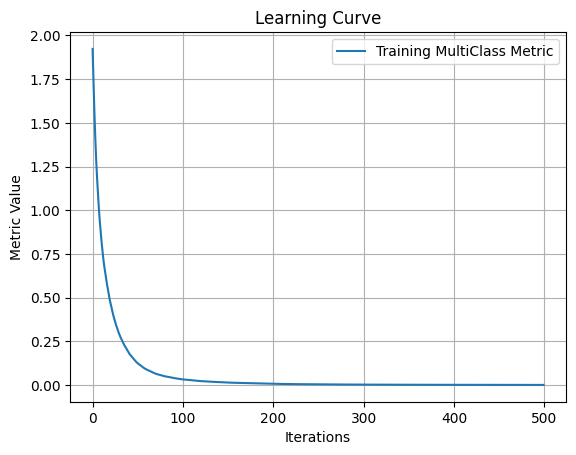

In [62]:
import matplotlib.pyplot as plt

# Plotting the learning curve
plt.plot(train_metric_values, label='Training MultiClass Metric')
plt.xlabel('Iterations')
plt.ylabel('Metric Value')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()


Classification Report - Training Set:
                             precision    recall  f1-score   support

        Noise_20_B007_1_123       1.00      1.00      1.00       150
        Noise_20_B014_1_190       1.00      1.00      1.00       145
        Noise_20_B021_1_227       1.00      1.00      1.00       140
       Noise_20_IR007_1_110       1.00      1.00      1.00       150
       Noise_20_IR021_1_214       1.00      1.00      1.00       133
     Noise_20_OR007_6_1_136       1.00      1.00      1.00       136
     Noise_20_OR014_6_1_202       1.00      1.00      1.00       132
     Noise_20_OR021_6_1_239       1.00      1.00      1.00       131
Noise_20__Time_Normal_1_098       1.00      1.00      1.00       139

                   accuracy                           1.00      1256
                  macro avg       1.00      1.00      1.00      1256
               weighted avg       1.00      1.00      1.00      1256

Classification Report - Test Set:
                            

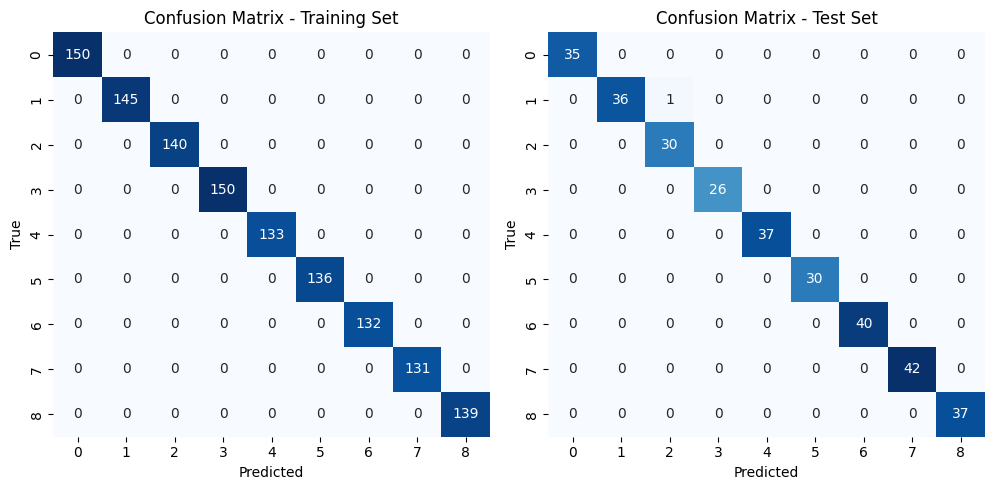

Deployment Duration: 0:10:14.455324


In [63]:
# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Training Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.savefig('C-Matrix.svg', format='svg')
plt.show()

end_time = datetime.now()
print('Deployment Duration: {}'.format(end_time - start_time))

In [64]:
final_model.fit(X_train, y_train, eval_set=(X_test, y_test))

# Evaluate train accuracy
result_train = final_model.score(X_train, y_train)
print("Train Accuracy : {}".format(result_train))

# Evaluate test accuracy
result_test = final_model.score(X_test, y_test)
print("Test Accuracy : {}".format(result_test))

# Predictions
y_pred_train = final_model.predict(X_train)
y_pred_test = final_model.predict(X_test)

# Classification report
print("Classification Report - Training Set:")
print(classification_report(y_train, y_pred_train))

print("Classification Report - Test Set:")
print(classification_report(y_test, y_pred_test))

0:	learn: 1.9227818	test: 1.9304102	best: 1.9304102 (0)	total: 190ms	remaining: 1m 34s
10:	learn: 0.8171683	test: 0.8324031	best: 0.8324031 (10)	total: 2.11s	remaining: 1m 33s
20:	learn: 0.4656225	test: 0.4833483	best: 0.4833483 (20)	total: 4.18s	remaining: 1m 35s
30:	learn: 0.2854546	test: 0.3031456	best: 0.3031456 (30)	total: 6.38s	remaining: 1m 36s
40:	learn: 0.1854652	test: 0.2027590	best: 0.2027590 (40)	total: 8.48s	remaining: 1m 34s
50:	learn: 0.1250241	test: 0.1409830	best: 0.1409830 (50)	total: 11.7s	remaining: 1m 42s
60:	learn: 0.0891319	test: 0.1045760	best: 0.1045760 (60)	total: 13.8s	remaining: 1m 39s
70:	learn: 0.0656440	test: 0.0810885	best: 0.0810885 (70)	total: 15.7s	remaining: 1m 34s
80:	learn: 0.0510236	test: 0.0668590	best: 0.0668590 (80)	total: 17.5s	remaining: 1m 30s
90:	learn: 0.0410701	test: 0.0575446	best: 0.0575446 (90)	total: 19.7s	remaining: 1m 28s
100:	learn: 0.0331267	test: 0.0499806	best: 0.0499806 (100)	total: 21.7s	remaining: 1m 25s
110:	learn: 0.0279559